Building a Flood Risk Analysis Pipeline for Lagos

 Step 1: Set Up Google Colab and Install Required Libraries

In [5]:
 # Step 1: Set Up Google Colab and Install Required Libraries
 # 1.1 Install Required Python Libraries
!pip install geemap earthengine-api geopandas rasterio folium contextily shapely fiona descartes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.3 MB/s eta 0:00:00


1.2 Authenticate and Initialize Google Earth Engine

In [6]:
import ee
import geemap

# Authenticate GEE (only needed once per session)
ee.Authenticate()

# Initialize GEE
ee.Initialize(project='oluwatosinilesanmi-47')


Step 2: Define the Area of Interest (Lagos, Nigeria)

In [7]:
# Define the area of interest (Lagos, Nigeria) using minimum and maximum coordinates
aoi = ee.Geometry.Rectangle([2.926, 6.358, 3.734, 6.673])  # [minLng, minLat, maxLng, maxLat]

# Visualize the area
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(aoi, {}, "Lagos Boundary")
Map

Map(center=[6.515644095813159, 3.330000000000076], controls=(WidgetControl(options=['position', 'transparent_b…

Step 3: Acquire and Preprocess Spatial Data
We need four essential datasets from GEE:

*   Digital Elevation Model (DEM) for terrain analysis
*   Rainfall data to assess precipitation levels
*   Land Use/Land Cover (LULC) for surface classification
*   Population data to evaluate human exposure to floods

3.1 Load Digital Elevation Model (DEM)

In [8]:
# We use the SRTM DEM (30m resolution) to extract elevation and identify low-lying areas prone to flooding.
# Load SRTM DEM dataset
dem = ee.Image("USGS/SRTMGL1_003").clip(aoi)

# Define visualization parameters
dem_vis = {'min': 0, 'max': 100, 'palette': ['blue', 'green', 'yellow', 'red']}

# Add DEM layer to map
Map.addLayer(dem, dem_vis, "Digital Elevation Model (DEM)")
Map


Map(bottom=126617.0, center=[6.515644095813159, 3.330000000000076], controls=(WidgetControl(options=['position…

In [9]:
# Download DEM as GeoTIFF
geemap.ee_export_image(dem, filename="dem_lagos.tif", scale=30, region=aoi)


Generating URL ...
Please wait ...
Data downloaded to /content/dem_lagos.tif


3.2 Load Rainfall Data (CHIRPS Precipitation)

In [10]:
# We use CHIRPS rainfall data (Climate Hazards Group InfraRed Precipitation) to assess flood risk due to precipitation.
# Load CHIRPS Rainfall dataset
rainfall = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
    .filterBounds(aoi) \
    .filterDate('2020-01-01', '2023-12-31') \
    .mean() \
    .clip(aoi)

# Define visualization parameters
rainfall_vis = {'min': 0, 'max': 100, 'palette': ['white', 'blue']}

# Add rainfall layer to map
Map.addLayer(rainfall, rainfall_vis, "Rainfall")
Map


Map(bottom=126617.0, center=[6.515644095813159, 3.330000000000076], controls=(WidgetControl(options=['position…

In [11]:
# Download Rainfall Data as GeoTIFF
geemap.ee_export_image(rainfall, filename="rainfall_lagos.tif", scale=5000, region=aoi)


Generating URL ...
Please wait ...
Data downloaded to /content/rainfall_lagos.tif


3.3 Load Land Cover Data (ESA WorldCover 2020)

In [12]:
# Land cover influences flood behavior. Urban areas reduce infiltration, while wetlands indicate flood-prone zones.
# Load ESA WorldCover 2020 land cover dataset
lulc = ee.ImageCollection("ESA/WorldCover/v100").select('Map').first().clip(aoi)

# Define visualization parameters
lulc_vis = {'min': 10, 'max': 100, 'palette': ['green', 'yellow', 'red']}

# Add LULC layer to map
Map.addLayer(lulc, lulc_vis, "Land Cover")
Map


Map(bottom=126617.0, center=[6.515644095813159, 3.330000000000076], controls=(WidgetControl(options=['position…

In [13]:
# Download LULC Data as GeoTIFF
geemap.ee_export_image(lulc, filename="lulc_lagos.tif", scale=30, region=aoi)

Generating URL ...
Please wait ...
Data downloaded to /content/lulc_lagos.tif


3.4 Load Population Density Data (WorldPop)

In [14]:
# We use WorldPop data to assess population exposure to floods
# Load WorldPop population dataset
population = ee.ImageCollection("WorldPop/GP/100m/pop") \
    .filterBounds(aoi) \
    .filterDate("2020-01-01", "2020-12-31") \
    .mean() \
    .clip(aoi)

# Define visualization parameters
pop_vis = {'min': 0, 'max': 5000, 'palette': ['white', 'red']}

# Add population layer to map
Map.addLayer(population, pop_vis, "Population Density")
Map


Map(bottom=126617.0, center=[6.515644095813159, 3.330000000000076], controls=(WidgetControl(options=['position…

In [15]:
# Download Population Data as GeoTIFF
geemap.ee_export_image(population, filename="population_lagos.tif", scale=100, region=aoi)

Generating URL ...
Please wait ...
Data downloaded to /content/population_lagos.tif


Step 4: Perform Flood Risk Analysis

We'll compute Flood Risk Index (FRI) based on:
*   Low-lying elevation (DEM)
*   High precipitation levels (Rainfall)
*   High urban development & wetlands (LULC)
*   High population exposure (WorldPop)

4.1 Normalize Data for Analysis

In [16]:
# Convert to numpy arrays for calculations
dem_array = geemap.ee_to_numpy(dem, scale=100)  # Use a consistent scale, e.g., 100 meters
rainfall_array = geemap.ee_to_numpy(rainfall, scale=100)  # Use the same scale
lulc_array = geemap.ee_to_numpy(lulc, scale=100)
pop_array = geemap.ee_to_numpy(population, scale=100)  # Use the same scale

# Get the minimum shape among all arrays
min_shape = min(dem_array.shape, rainfall_array.shape, lulc_array.shape, pop_array.shape)

# Resize all arrays to the minimum shape
dem_array = dem_array[:min_shape[0], :min_shape[1], :min_shape[2]]
rainfall_array = rainfall_array[:min_shape[0], :min_shape[1], :min_shape[2]]
lulc_array = lulc_array[:min_shape[0], :min_shape[1], :min_shape[2]]
pop_array = pop_array[:min_shape[0], :min_shape[1], :min_shape[2]]


# Normalize datasets to a 0-1 range
norm_dem = (dem_array - dem_array.min()) / (dem_array.max() - dem_array.min())
norm_rainfall = (rainfall_array - rainfall_array.min()) / (rainfall_array.max() - rainfall_array.min())
norm_lulc = (lulc_array - lulc_array.min()) / (lulc_array.max() - lulc_array.min())
norm_pop = (pop_array - pop_array.min()) / (pop_array.max() - pop_array.min())

# Compute Flood Risk Index
flood_risk = (1 - norm_dem) * 0.4 + norm_rainfall * 0.3 + norm_lulc * 0.2 + norm_pop * 0.1

4.2 Visualize Flood Risk

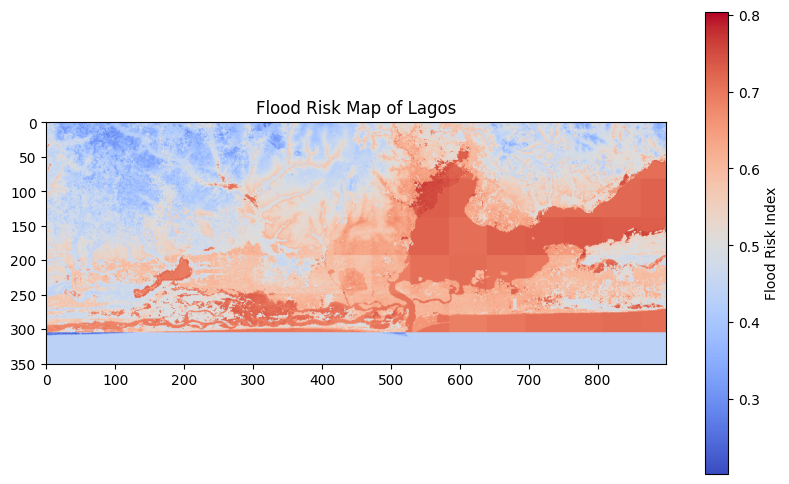

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(flood_risk, cmap='coolwarm')
plt.colorbar(label="Flood Risk Index")
plt.title("Flood Risk Map of Lagos")
plt.show()


 Step 5: Save and Export Flood Risk Data

In [18]:
#  Save as Image
import matplotlib.pyplot as plt
import numpy as np

# Reshape the flood_risk array to have 3 dimensions if it has only 2
if flood_risk.ndim == 2:
    flood_risk = flood_risk[:, :, np.newaxis]  # Add a third dimension

# If flood_risk still doesn't have 3 or 4 dimensions after reshaping,
# it might contain multiple bands.  In this case, select the first band (or another relevant one)
if flood_risk.ndim not in (3, 4):
    flood_risk = flood_risk[:, :, 0] # Select the first band
    flood_risk = flood_risk[:, :, np.newaxis] # Add a third dimension

# Convert the single-channel flood_risk array to a 3-channel RGB array
# by repeating the values across the 3 color channels.
# This assumes that the flood_risk values represent a grayscale image.
flood_risk_rgb = np.repeat(flood_risk, 3, axis=2)

# Now save the reshaped flood_risk array as an image
plt.imsave("flood_risk_lagos.png", flood_risk_rgb, cmap='coolwarm')

In [19]:
# Export as GeoTIFF
import rasterio

# Reshape flood_risk to have the expected dimensions: (height, width) for a single band
flood_risk_reshaped = flood_risk.squeeze()  # Remove dimensions of size 1

with rasterio.open(
    "flood_risk_lagos.tif", "w", driver="GTiff", height=flood_risk_reshaped.shape[0], width=flood_risk_reshaped.shape[1],
    count=1, dtype=flood_risk_reshaped.dtype
) as dst:
    dst.write(flood_risk_reshaped, 1)  # Write the reshaped array to the first band

Step 6: To visualize the flood risk map in an interactive map


6.1: Convert Flood Risk Array to an Earth Engine Image

Since we computed the Flood Risk Index (FRI) as a NumPy array, we need to:

1.   Reconstruct it as an Earth Engine image
1.   Rescale it to match the original DEM resolution
2.   Add it as a layer on an interactive map



 6.2: Convert NumPy Array to an Earth Engine Image

In [20]:
!pip install geemap --upgrade  # Update geemap to the latest version
!pip install rasterio

In [28]:
# We'll first reproject the flood risk data back to an Earth Engine Image and visualize it.
import numpy as np
import ee
import geemap
import rasterio

# Get projection information from the original DEM
with rasterio.open('/content/dem_lagos.tif') as dem_raster:
    dem_profile = dem_raster.profile

# Convert the flood risk array to an Earth Engine image
# by creating a raster and then uploading it to Earth Engine.
# Create a temporary GeoTIFF file from the flood risk data
with rasterio.open(
    "/content/temp_flood_risk.tif", "w", driver="GTiff",
    height=flood_risk.shape[0], width=flood_risk.shape[1],
    count=1, dtype=flood_risk.dtype,
    crs=dem_profile['crs'],
    transform=dem_profile['transform']
) as dst:
    dst.write(flood_risk.squeeze(), 1)  # Write the reshaped array to the first band


# Upload the temporary GeoTIFF to Earth Engine as an asset (replace with your asset path)
asset_id = 'users/oluwatosinilesanmi-47/flood_risk_lagos' # Replace with your asset ID
# Use geemap.ee_export_image instead of geemap.ee_upload which has been removed.

geemap.ee_export_image(  # Changed geemap.ee_upload to geemap.ee_export_image
    ee.Image.constant(flood_risk.squeeze()),  # Create ee.Image from flood_risk array
    filename=asset_id,  # Use asset_id as filename
    scale=dem_profile['transform'].a,  # Get scale from dem_profile
    region=aoi,  # Use aoi as region
    crs=dem_profile['crs'],  # Set CRS from dem_profile
    file_per_band=False  # Export as single-band image
)


# Load the asset as an Earth Engine image
flood_risk_image = ee.Image(asset_id).clip(aoi)

# Define visualization parameters for flood risk
flood_risk_vis = {
    'min': 0,
    'max': 1,
    'palette': ['blue', 'yellow', 'red']
} # Added the missing closing curly brace

The filename must end with .tif


6.3: Add Basemap and Export as GeoTIFF

In [31]:
# Add OpenStreetMap basemap
Map.add_basemap("OpenStreetMap")

# Export flood risk layer as GeoTIFF
geemap.ee_export_image(flood_risk_image, filename="/content/flood_risk_lagos.tif", scale=30, region=aoi)


OpenStreetMap has been already added before.
Generating URL ...
An error occurred while downloading.
Image.load: Image asset 'users/oluwatosinilesanmi-47/flood_risk_lagos' not found (does not exist or caller does not have access).


In [44]:
!pip install geemap --upgrade # Update geemap to the latest version to ensure eefolium is included.
import geemap.foliumap as eefolium # Update import statement to use geemap.foliumap if eefolium is not available
!pip install geemap --upgrade  # install the latest version of geemap
# import geemap.eefolium as eefolium # Update import statement to use geemap.eefolium if eefolium is not available

# eefolium is part of geemap.foliumap. It's not a separate module.
# Therefore, if you have geemap.foliumap imported, you can call eefolium functions directly.
# For instance:
eefolium.Map()  # Create an eefolium Map object

# Also, ee.Image objects can be displayed using geemap.Map.addLayer
# No need to convert it to an ee.Image again.